In [3]:
import os
import sys
import csv
import textwrap
import warnings

sys.path.append(os.path.dirname(os.getcwd()))

import matplotlib.pyplot as plt
import numpy as np

from adjustText import adjust_text

from src.utils.checkpoint import load_params, load_variational

from src.model.functions import new_user_base, new_user_var

warnings.simplefilter("ignore")

#### Load Embeddings

In [4]:
params = load_params("../artifacts/model/32m_users_training_feat_2.npz")
feat_embeddings_2d = params["feat_embedding"]
idx_to_feat_id = params['idx_to_feat_id']

In [5]:
params = load_params("../artifacts/model/32m_users_training_2.npz")
movie_embeddings_2d = params["movie_embedding"]

In [6]:
params = load_params("../artifacts/model/32m_users_training_10.npz")
r_lambda = params["r_lambda"]
r_tau = params["r_tau"]
r_gamma = params["r_gamma"]
idx_to_user_id = params["idx_to_user_id"]
idx_to_movie_id = params["idx_to_movie_id"]
user_bias = params["user_bias"]
movie_bias = params["movie_bias"]
user_embeddings = params["user_embedding"]
movie_embeddings = params["movie_embedding"]

In [7]:
params = load_params("../artifacts/model/32m_users_training_feat_10.npz")
user_bias_with_f = params["user_bias"]
movie_bias_with_f = params["movie_bias"]
user_embeddings_with_f = params["user_embedding"]
movie_embeddings_with_f = params["movie_embedding"]

In [8]:
params = load_variational("../artifacts/model/32m_variational_10.npz")
user_mean_bias = params["user_mean_bias"]
movie_mean_bias = params["movie_mean_bias"]
user_mean_embedding = params["user_mean_embedding"]
movie_mean_embedding = params["movie_mean_embedding"]
user_var_bias = params["user_var_bias"]
movie_var_bias = params["movie_var_bias"]
user_var_embedding = params["user_var_embedding"]
movie_var_embedding = params["movie_var_embedding"]

#### Load Data

In [9]:
user_id_to_idx = {v:k for k, v in enumerate(idx_to_user_id)}
movie_id_to_idx = {v:k for k, v in enumerate(idx_to_movie_id)}

user_movie = [([],[]) for _ in range(len(idx_to_user_id))]
movie_user = [([],[]) for _ in range(len(idx_to_movie_id))]

with open("../data/ml-32m/ratings.csv") as f:
    reader = csv.reader(f)
    _ = next(reader)
    for row in reader:
        user_id, movie_id, rating, _ = row
        user_idx = user_id_to_idx[user_id]
        movie_idx = movie_id_to_idx[movie_id]
        user_movie[user_idx][0].append(movie_idx)
        user_movie[user_idx][1].append(float(rating))
        movie_user[movie_idx][0].append(user_idx)
        movie_user[movie_idx][1].append(float(rating))

movie_id_to_title = {}
title_to_movie_id = {}
movie_id_to_genres = {}

with open("../data/ml-32m/movies.csv") as f:
    reader = csv.reader(f)
    _ = next(reader)
    for row in reader:
        movie_id, title, genres = row
        movie_id_to_title[movie_id] = title
        title_to_movie_id[title] = movie_id
        movie_id_to_genres[movie_id] = genres

idx_to_title = {v: movie_id_to_title[k] for k, v in movie_id_to_idx.items()}

#### Movie Embedding Space

In [49]:
movie_choice = list(
    filter(
        lambda x: (
            ("lord of the rings: " in idx_to_title[x].lower())
            or ("american pie " in idx_to_title[x].lower())
            or ("la la land " in idx_to_title[x].lower())
            or ("despicable me " in idx_to_title[x].lower())
            or ("hotel transylvania " in idx_to_title[x].lower())
        ),
        range(len(movie_bias))
    )
)

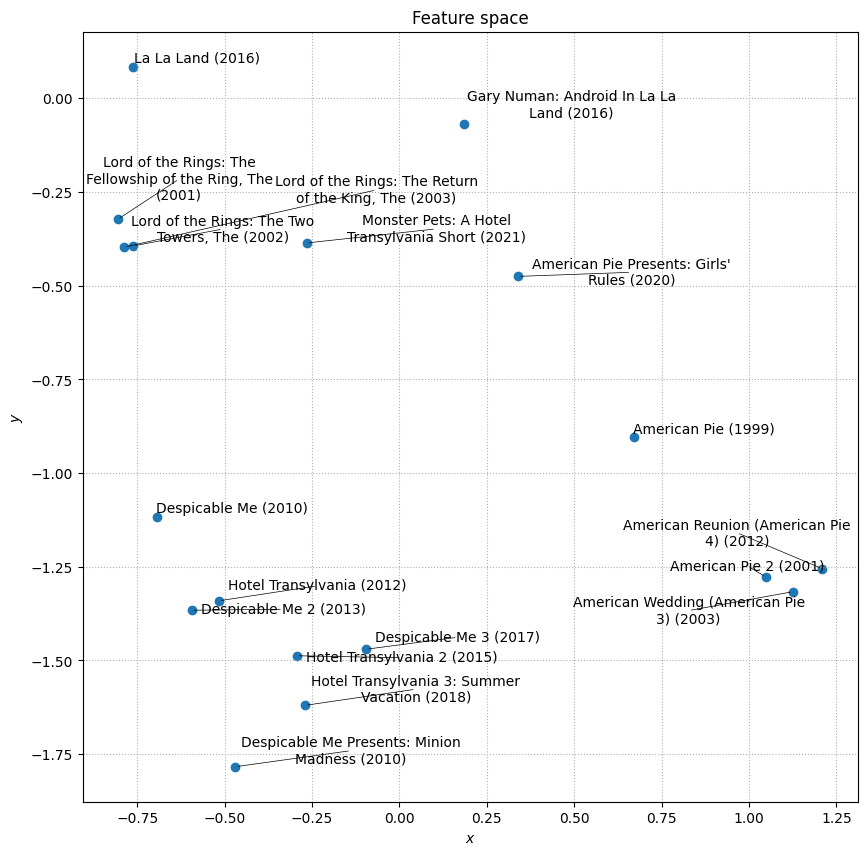

In [50]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_choice, 0], movie_embeddings_2d[movie_choice, 1])

texts = []
for i in movie_choice:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Feature space")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/32m_movie_embedd_space.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Feature Embedding Space

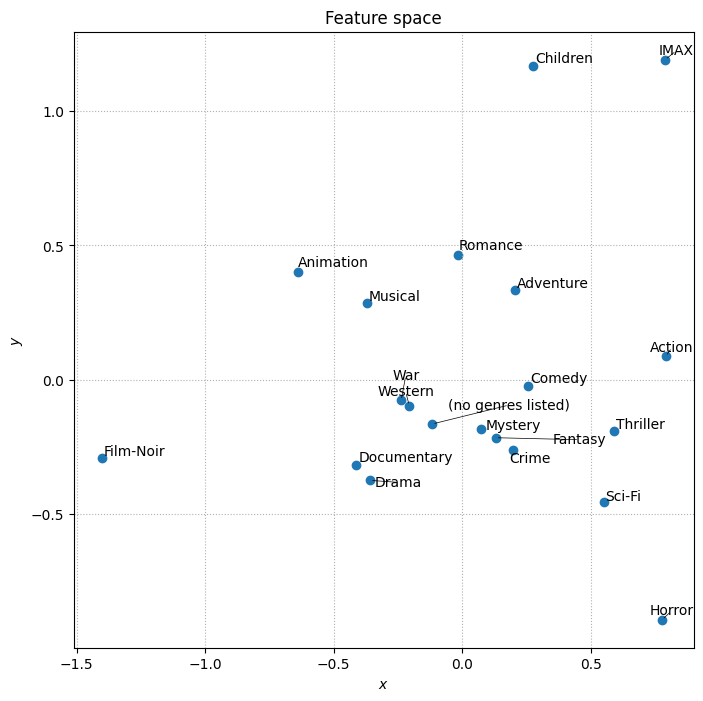

In [11]:
plt.subplots(figsize=(8, 8))

plt.scatter(feat_embeddings_2d[:,0], feat_embeddings_2d[:,1])

texts = []
for i, x in enumerate(feat_embeddings_2d):
    texts.append(plt.annotate(idx_to_feat_id[i], x))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Feature space")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/32m_feature_2_space.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Dummy User Embedding

In [8]:
lord_of_the_ring_title = "Lord of the Rings: The Fellowship of the Ring, The (2001)"
lord_of_the_ring_id = title_to_movie_id[lord_of_the_ring_title]
lord_of_the_ring_rating = 5.0
lord_of_the_ring_idx = movie_id_to_idx[lord_of_the_ring_id]

print(f"Movie: {lord_of_the_ring_title}")
print(f"Degree: {len(movie_user[lord_of_the_ring_idx][0])}")
print(f"Genres: {movie_id_to_genres[lord_of_the_ring_id]}")

Movie: Lord of the Rings: The Fellowship of the Ring, The (2001)
Degree: 73122
Genres: Adventure|Fantasy


In [93]:
np.random.seed(42)

dummy_embedding, _ = new_user_base(
    [(lord_of_the_ring_idx, lord_of_the_ring_rating)],
    movie_embeddings,
    movie_bias,
    r_lambda,
    r_gamma,
    r_tau,
    n_iter=10,
)

dummy_embedding_f, _ = new_user_base(
    [(lord_of_the_ring_idx, lord_of_the_ring_rating)],
    movie_embeddings_with_f,
    movie_bias_with_f,
    r_lambda,
    r_gamma,
    r_tau,
    n_iter=5,
)

dummy_embedding_v, _, _, _ = new_user_var(
    [(lord_of_the_ring_idx, lord_of_the_ring_rating)],
    movie_mean_embedding,
    movie_var_embedding,
    movie_mean_bias,
    r_lambda,
    r_gamma,
    r_tau,
    n_iter=5,
)

#### Dummy User Prediction

In [94]:
def compute_scores(embeddings, bias, query):
    return embeddings @ query + bias

def compute_ranking(embeddings, bias, query):
    scores = compute_scores(embeddings, bias, query)
    ranking = np.argsort(scores)[::-1]

    return ranking, scores[ranking]

##### Base Model

In [95]:
limit = 10 

bias_scale = 0.1
min_degree = 10

ranking, _ = compute_ranking(movie_embeddings, bias_scale * movie_bias, dummy_embedding[0])

iterator = enumerate(filter(lambda idx: len(movie_user[idx][0]) > min_degree, ranking))

print("Top Prediction")

for i, idx in iterator:
    if i == limit: break
    pred_id = idx_to_movie_id[idx]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx][0]), " - genres:", movie_id_to_genres[pred_id])

Top Prediction
1 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449  - genres: Action|Adventure|Drama|Fantasy
2 - Lord of the Rings: The Fellowship of the Ring, The (2001)  - degree: 73122  - genres: Adventure|Fantasy
3 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463  - genres: Adventure|Fantasy
4 - Star Wars: Episode V - The Empire Strikes Back (1980)  - degree: 72151  - genres: Action|Adventure|Sci-Fi
5 - Star Wars: Episode IV - A New Hope (1977)  - degree: 85010  - genres: Action|Adventure|Sci-Fi
6 - Star Wars: Episode VI - Return of the Jedi (1983)  - degree: 67496  - genres: Action|Adventure|Sci-Fi
7 - Harry Potter and the Deathly Hallows: Part 2 (2011)  - degree: 20227  - genres: Action|Adventure|Drama|Fantasy|Mystery|IMAX
8 - Star Wars: Episode III - Revenge of the Sith (2005)  - degree: 24773  - genres: Action|Adventure|Sci-Fi
9 - Harry Potter and the Deathly Hallows: Part 1 (2010)  - degree: 20969  - genres: Action|Adventure|Fantasy|IMAX


##### Model with Features

In [96]:
limit = 10 

bias_scale = 0.1
min_degree = 10

ranking, _ = compute_ranking(movie_embeddings_with_f, bias_scale * movie_bias_with_f, dummy_embedding_f[0])

iterator = enumerate(filter(lambda idx: len(movie_user[idx][0]) > min_degree, ranking))

print("Top Prediction")

for i, idx in iterator:
    if i == limit: break
    pred_id = idx_to_movie_id[idx]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx][0]), " - genres:", movie_id_to_genres[pred_id])

Top Prediction
1 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449  - genres: Action|Adventure|Drama|Fantasy
2 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463  - genres: Adventure|Fantasy
3 - Lord of the Rings: The Fellowship of the Ring, The (2001)  - degree: 73122  - genres: Adventure|Fantasy
4 - Star Wars: Episode III - Revenge of the Sith (2005)  - degree: 24773  - genres: Action|Adventure|Sci-Fi
5 - Hobbit: An Unexpected Journey, The (2012)  - degree: 16149  - genres: Adventure|Fantasy|IMAX
6 - Hobbit: The Desolation of Smaug, The (2013)  - degree: 12175  - genres: Adventure|Fantasy|IMAX
7 - Star Wars: Episode IV - A New Hope (1977)  - degree: 85010  - genres: Action|Adventure|Sci-Fi
8 - Star Wars: Episode VI - Return of the Jedi (1983)  - degree: 67496  - genres: Action|Adventure|Sci-Fi
9 - Star Wars: Episode V - The Empire Strikes Back (1980)  - degree: 72151  - genres: Action|Adventure|Sci-Fi
10 - Star Wars: Episode II - Attack of the Clo

##### Variational Model

In [97]:
limit = 10 

bias_scale = 0.1
min_degree = 10

ranking, _ = compute_ranking(movie_mean_embedding, bias_scale * movie_mean_bias, dummy_embedding_v[0])

iterator = enumerate(filter(lambda idx: len(movie_user[idx][0]) > min_degree, ranking))

print("Top Prediction")

for i, idx in iterator:
    if i == limit: break
    pred_id = idx_to_movie_id[idx]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx][0]), " - genres:", movie_id_to_genres[pred_id])

Top Prediction
1 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449  - genres: Action|Adventure|Drama|Fantasy
2 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463  - genres: Adventure|Fantasy
3 - Lord of the Rings: The Fellowship of the Ring, The (2001)  - degree: 73122  - genres: Adventure|Fantasy
4 - Star Wars: Episode III - Revenge of the Sith (2005)  - degree: 24773  - genres: Action|Adventure|Sci-Fi
5 - Star Wars: Episode V - The Empire Strikes Back (1980)  - degree: 72151  - genres: Action|Adventure|Sci-Fi
6 - Star Wars: Episode IV - A New Hope (1977)  - degree: 85010  - genres: Action|Adventure|Sci-Fi
7 - Star Wars: Episode VI - Return of the Jedi (1983)  - degree: 67496  - genres: Action|Adventure|Sci-Fi
8 - Star Wars: Episode II - Attack of the Clones (2002)  - degree: 27415  - genres: Action|Adventure|Sci-Fi|IMAX
9 - Hobbit: An Unexpected Journey, The (2012)  - degree: 16149  - genres: Adventure|Fantasy|IMAX
10 - Hobbit: The Desolation of S

#### Top Polarizing Movies

In [98]:
limit = 20 

min_similarity  = 0.9
min_degree      = 10

movie_norm = np.linalg.norm(movie_embeddings, axis=1)
norm_rank = np.argsort(movie_norm)[::-1]
movie_bag = []

for idx in norm_rank:
    if len(movie_bag) == limit: break
    if len(movie_user[idx][0]) < min_degree: continue

    if len(movie_bag) == 0:
        movie_bag.append(idx)
        continue
    
    inner_prod = np.sum(movie_embeddings[movie_bag] * movie_embeddings[idx], axis=1)
    norm_movie_at_idx = movie_norm[idx]
    norm_movie_in_bag = movie_norm[movie_bag]
    
    if ((inner_prod/(norm_movie_in_bag * norm_movie_at_idx)) < 0.9).all():
        movie_bag.append(idx)

iterator = enumerate(movie_bag)

print("Top Polarizing")

for i, idx in iterator:
    if i == limit: break
    pred_id = idx_to_movie_id[idx]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx][0]), " - genres:", movie_id_to_genres[pred_id])

Top Polarizing
1 - Dumb & Dumber (Dumb and Dumber) (1994)  - degree: 36802  - genres: Adventure|Comedy
2 - Star Wars: Episode V - The Empire Strikes Back (1980)  - degree: 72151  - genres: Action|Adventure|Sci-Fi
3 - Harry Potter and the Deathly Hallows: Part 2 (2011)  - degree: 20227  - genres: Action|Adventure|Drama|Fantasy|Mystery|IMAX
4 - Blair Witch Project, The (1999)  - degree: 22780  - genres: Drama|Horror|Thriller
5 - Titanic (1997)  - degree: 45767  - genres: Drama|Romance
6 - Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan (2006)  - degree: 19566  - genres: Comedy
7 - Avengers: Infinity War - Part II (2019)  - degree: 11811  - genres: Action|Adventure|Sci-Fi
8 - Rocky (1976)  - degree: 20682  - genres: Drama
9 - Saw (2004)  - degree: 12829  - genres: Horror|Mystery|Thriller
10 - Toy Story 2 (1999)  - degree: 32683  - genres: Adventure|Animation|Children|Comedy|Fantasy
11 - Dark Knight Rises, The (2012)  - degree: 30369  - genres: Action|Ad

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


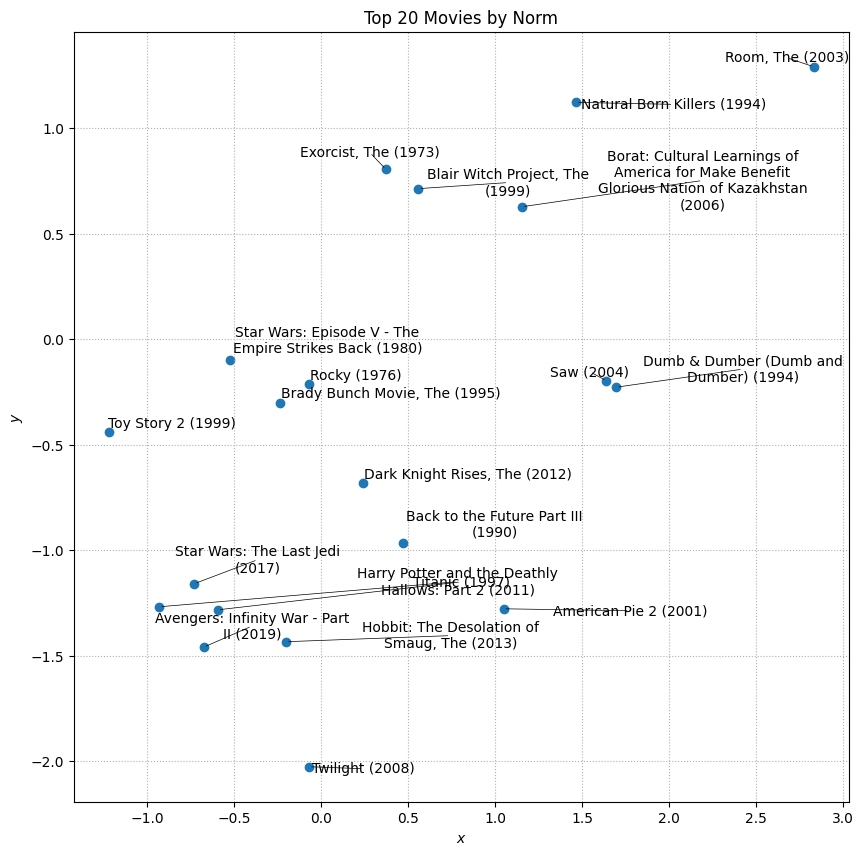

In [99]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_bag, 0], movie_embeddings_2d[movie_bag, 1])

texts = []
for i in movie_bag:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Top 20 Movies by Norm")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/top_polarizing_movie.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Less Polarizing Movies

In [102]:
limit = 20 

min_similarity  = 0.9
min_degree      = 100

movie_norm = np.linalg.norm(movie_embeddings, axis=1)
norm_rank = np.argsort(movie_norm)
movie_bag = []

for idx in norm_rank:
    if len(movie_bag) == limit: break
    if len(movie_user[idx][0]) < min_degree: continue

    if len(movie_bag) == 0:
        movie_bag.append(idx)
        continue
    
    inner_prod = np.sum(movie_embeddings[movie_bag] * movie_embeddings[idx], axis=1)
    norm_movie_at_idx = movie_norm[idx]
    norm_movie_in_bag = movie_norm[movie_bag]
    
    if ((inner_prod/(norm_movie_in_bag * norm_movie_at_idx)) < 0.9).all():
        movie_bag.append(idx)

iterator = enumerate(movie_bag)

print("Top Polarizing")

for i, idx in iterator:
    if i == limit: break
    pred_id = idx_to_movie_id[idx]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx][0]), " - genres:", movie_id_to_genres[pred_id])

Top Polarizing
1 - Border, The (1982)  - degree: 108  - genres: Drama
2 - Where the Sidewalk Ends (1950)  - degree: 101  - genres: Crime|Drama|Film-Noir
3 - Bobby Fischer Against the World (2011)  - degree: 172  - genres: Documentary
4 - Dead End (1937)  - degree: 122  - genres: Crime|Drama|Film-Noir
5 - Shiri (Swiri) (1999)  - degree: 176  - genres: Action|Drama|Romance|Thriller
6 - Just Another Love Story (Kærlighed på film) (2007)  - degree: 101  - genres: Crime|Drama|Thriller
7 - Senior Year (2022)  - degree: 100  - genres: Comedy
8 - Soft Skin, The (La peau douce) (1964)  - degree: 100  - genres: Drama
9 - Ballad of Cable Hogue, The (1970)  - degree: 206  - genres: Comedy|Western
10 - Horde, The (La Horde) (2009)  - degree: 111  - genres: Action|Horror|Thriller
11 - White Material (2009)  - degree: 118  - genres: Drama|Mystery|Thriller|War
12 - Black Sunday (1977)  - degree: 209  - genres: Action|Drama|Thriller
13 - Stillwater (2021)  - degree: 155  - genres: Drama|Thriller
14 - M

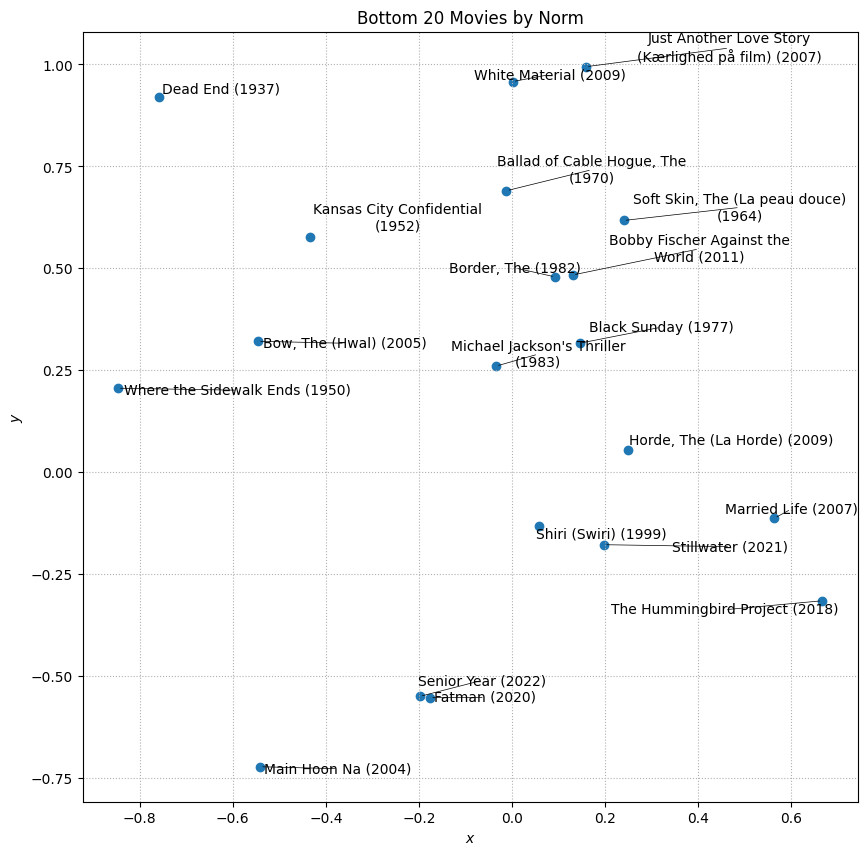

In [103]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_bag, 0], movie_embeddings_2d[movie_bag, 1])

texts = []
for i in movie_bag:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Bottom 20 Movies by Norm")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/bottom_polarizing_movie.pdf", format="pdf", bbox_inches='tight')
plt.show()

---